# Disease Classifier of cell nexus

In [1]:
#Import all the necessary files

import datetime
from geneformer import Classifier
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from geneformer import TranscriptomeTokenizer, DataCollatorForCellClassification 


In [3]:
import datetime
from geneformer import Classifier

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "disease_classifier_cellnexus"
output_dir = f"/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/{datestamp}"
!mkdir -p $output_dir

In [6]:
#Reading the anndata object
adata=sc.read_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/disease/geneformer_2048/complete_anndata/complete_anndata.h5ad")
adata.obs.cell_type.describe()
adata.obs.disease.describe()
adata.obs.dataset_id.describe()

count                                   629990
unique                                      26
top       21d3e683-80a4-4d9b-bc89-ebb2df513dde
freq                                    100000
Name: dataset_id, dtype: object

Disease distribution:
disease
COVID-19    326358
normal      303632
Name: count, dtype: int64


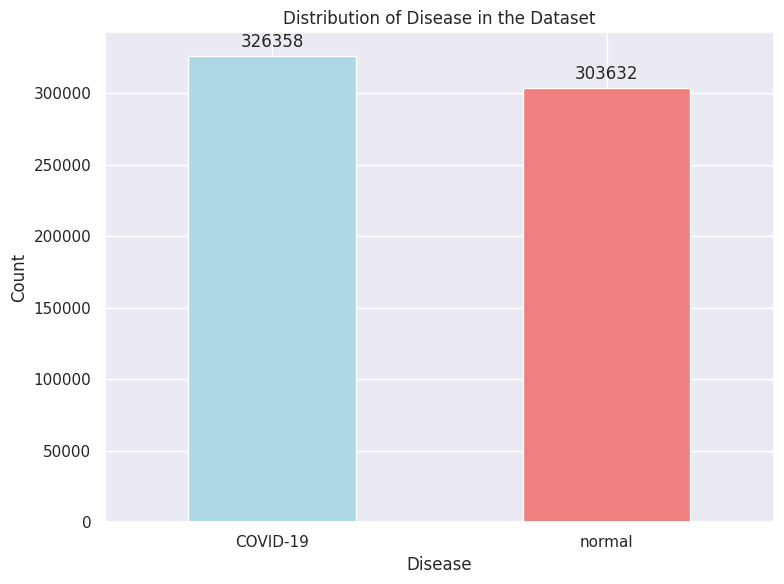

In [7]:
# Get the sex distribution
disease_counts = adata.obs.disease.value_counts()
print("Disease distribution:")
print(disease_counts)

# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))
disease_counts.plot(kind='bar', ax=ax, color=['lightblue', 'lightcoral'])
ax.set_title('Distribution of Disease in the Dataset')
ax.set_xlabel('Disease')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

# Add count labels on top of bars
for i, v in enumerate(disease_counts.values):
    ax.text(i, v + max(disease_counts.values) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [9]:
# Geneformer directories for the 2048 model
gene_median_file_2048="/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/gene_median_dictionary_gc30M.pkl" 
token_dictionary_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl"
gene_mapping_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/ensembl_mapping_dict_gc30M.pkl"

#Defining the tokenizer
tk = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid","disease": "disease","cell_type": "cell_type","dataset_id": "dataset_id"},
                            model_input_size = 2048,
                            special_token = False,
                            gene_median_file=gene_median_file_2048 ,
                            token_dictionary_file= token_dictionary_file_2048,
                            gene_mapping_file= gene_mapping_file_2048)

In [ ]:
#directory for the anndata object
data_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/data/disease/geneformer_2048/complete_anndata/"
#directory for the tokenized data
token_dir="/hpcfs/users/a1841503/Geneformer/cellnexus/data/disease/geneformer_2048/complete_tokenized/"

#tokenizing the data
tk.tokenize_data(data_directory=data_directory,
                 output_directory=token_dir, 
                 output_prefix="disease_cell_type", 
                 file_format="h5ad")

In [ ]:
# Plot dataset_id vs disease
dataset_disease_counts = adata.obs.groupby(['dataset_id', 'disease']).size().unstack(fill_value=0)

# Create a stacked bar plot
fig, ax = plt.subplots(figsize=(15, 8))
dataset_disease_counts.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'lightcoral'])
ax.set_title('Distribution of Disease by Dataset ID')
ax.set_xlabel('Dataset ID')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Disease')

plt.tight_layout()
plt.show()

# Also show the unique dataset IDs
print("Unique dataset IDs:")
print(adata.obs.dataset_id.unique())

In [8]:
filter_data_dict={"disease":['normal', 'COVID-19']}
training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
}
# OF NOTE: model_version should match version of model to be used (V1 or V2) to use the correct token dictionary
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease", "states": "all"},
                filter_data=filter_data_dict,
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 2,
                num_crossval_splits = 1,
                forward_batch_size=100,
                nproc=16)

In [8]:
datset_id_list=['9dbab10c-118d-496b-966a-67f1763a6b7d',
 '242c6e7f-9016-4048-af70-d631f5eea188',
 '1b9d8702-5af8-4142-85ed-020eb06ec4f6',
 '21d3e683-80a4-4d9b-bc89-ebb2df513dde',
 '30cd5311-6c09-46c9-94f1-71fe4b91813c',
 '3faad104-2ab8-4434-816d-474d8d2641db',
 '50eb1e23-b8d4-4f76-a184-44e5541fa05a',
 '53d208b0-2cfd-4366-9866-c3c6114081bc',
 '59b69042-47c2-47fd-ad03-d21beb99818f',
 '5af90777-6760-4003-9dba-8f945fec6fdf',
 '5bc42b88-bb76-4954-927b-8bb7369adc64',
 '5e717147-0f75-4de1-8bd2-6fda01b8d75f',
 '74cff64f-9da9-4b2a-9b3b-8a04a1598040',
 '79ef1959-a6b4-4cac-82ca-30feaec48df1',
 '84230ea4-998d-4aa8-8456-81dd54ce23af',
 '881fe679-c6e0-45a3-9427-c4e81be6921f',
 '8c42cfd0-0b0a-46d5-910c-fc833d83c45e',
 '8a554710-08bc-4005-87cd-da9675bdc2e7',
 'b0e547f0-462b-4f81-b31b-5b0a5d96f537',
 'c2a461b1-0c15-4047-9fcb-1f966fe55100',
 'c7775e88-49bf-4ba2-a03b-93f00447c958',
 'cab0bc48-744c-461b-aaf4-7bf2cb7af00d',
 'db59611b-42de-4035-93aa-1ed39f38b467',
 'ed5d841d-6346-47d4-ab2f-7119ad7e3a35',
 'eeacb0c1-2217-4cf6-b8ce-1f0fedf1b569',
 'fa8605cf-f27e-44af-ac2a-476bee4410d3']

In [17]:
# Manually balanced splits
# argument attr_to_split set to "dataset_id" and attr_to_balance set to ["Disease"]
test_ids= ['8c42cfd0-0b0a-46d5-910c-fc833d83c45e', '84230ea4-998d-4aa8-8456-81dd54ce23af']
train_ids= ['9dbab10c-118d-496b-966a-67f1763a6b7d','242c6e7f-9016-4048-af70-d631f5eea188','1b9d8702-5af8-4142-85ed-020eb06ec4f6','21d3e683-80a4-4d9b-bc89-ebb2df513dde','30cd5311-6c09-46c9-94f1-71fe4b91813c','3faad104-2ab8-4434-816d-474d8d2641db','50eb1e23-b8d4-4f76-a184-44e5541fa05a','53d208b0-2cfd-4366-9866-c3c6114081bc','59b69042-47c2-47fd-ad03-d21beb99818f','5af90777-6760-4003-9dba-8f945fec6fdf','5bc42b88-bb76-4954-927b-8bb7369adc64','5e717147-0f75-4de1-8bd2-6fda01b8d75f','74cff64f-9da9-4b2a-9b3b-8a04a1598040','79ef1959-a6b4-4cac-82ca-30feaec48df1','881fe679-c6e0-45a3-9427-c4e81be6921f','8a554710-08bc-4005-87cd-da9675bdc2e7','b0e547f0-462b-4f81-b31b-5b0a5d96f537','c2a461b1-0c15-4047-9fcb-1f966fe55100','c7775e88-49bf-4ba2-a03b-93f00447c958','cab0bc48-744c-461b-aaf4-7bf2cb7af00d','db59611b-42de-4035-93aa-1ed39f38b467','ed5d841d-6346-47d4-ab2f-7119ad7e3a35','eeacb0c1-2217-4cf6-b8ce-1f0fedf1b569','fa8605cf-f27e-44af-ac2a-476bee4410d3']
train_test_id_split_dict = {"attr_key": "dataset_id",
                            "train": train_ids,
                            "test": test_ids}
attr_to_balance =["disease"] 
input_data_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/disease/geneformer_2048/complete_tokenized/disease_cell_type.dataset"
# Example input_data_file for 30M model: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
cc.prepare_data(input_data_file=input_data_file,
                output_directory=output_dir,
                output_prefix=output_prefix,
                attr_to_balance=attr_to_balance,
                split_id_dict=train_test_id_split_dict)

In [ ]:
model_directory="/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000"
# V1 model: https://huggingface.co/ctheodoris/Geneformer/blob/main/Geneformer-V1-10M/model.safetensors
all_metrics = cc.validate(model_directory=model_directory,  # OF NOTE: SET TO V1 MODEL ABOVE, PROVIDE V1 MODEL PATH HERE
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled_train.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          n_hyperopt_trials=10)
                          # to optimize hyperparameters, set n_hyperopt_trials=100 (or alternative desired # of trials)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



2025-09-10 13:35:24,777	INFO worker.py:1841 -- Started a local Ray instance.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to

== Status ==
Current time: 2025-09-10 13:35:29 (running for 00:00:00.24)
Using FIFO scheduling algorithm.
Logical resource usage: 0/72 CPUs, 0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 1/10 (1 PENDING)
+---------------------+----------+-------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc   |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |       |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+-------+-----------------+---------------------+---------------

(_objective pid=1768478) Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
(_objective pid=1768478) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=1768478) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/45947 [00:00<?, ?it/s]
(_objective pid=1769498) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy 

== Status ==
Current time: 2025-09-10 13:45:29 (running for 00:10:00.33)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |     seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |          |                |                |
|---------------------+----------

 10%|▉         | 4515/45947 [09:10<1:23:57,  8.23it/s] [repeated 164x across cluster]


(_objective pid=1770435) {'loss': 0.401, 'grad_norm': 2.178386688232422, 'learning_rate': 6.705307221086191e-06, 'epoch': 0.1}


 10%|█         | 4595/45947 [09:17<1:24:10,  8.19it/s]


(_objective pid=1768478) {'loss': 0.4464, 'grad_norm': 19.96306037902832, 'learning_rate': 3.1220773390568996e-06, 'epoch': 0.1} [repeated 3x across cluster]


 20%|█▉        | 9083/45947 [18:23<1:15:20,  8.15it/s] [repeated 161x across cluster]


(_objective pid=1770435) {'loss': 0.2329, 'grad_norm': 6.929742336273193, 'learning_rate': 5.960219034761684e-06, 'epoch': 0.2}


 20%|█▉        | 9125/45947 [18:28<1:15:23,  8.14it/s] [repeated 161x across cluster]


(_objective pid=1769498) {'loss': 0.1706, 'grad_norm': 29.330121994018555, 'learning_rate': 4.061675612035925e-05, 'epoch': 0.2}


 20%|██        | 9377/45947 [18:59<1:14:36,  8.17it/s] [repeated 162x across cluster]


== Status ==
Current time: 2025-09-10 13:55:29 (running for 00:20:00.38)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |     seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |          |                |                |
|---------------------+----------

 30%|██▉       | 13605/45947 [27:31<1:06:39,  8.09it/s] [repeated 164x across cluster]


(_objective pid=1770435) {'loss': 0.2075, 'grad_norm': 26.04066276550293, 'learning_rate': 5.215130848437176e-06, 'epoch': 0.3} [repeated 3x across cluster]


 30%|██▉       | 13689/45947 [27:41<1:04:30,  8.33it/s] [repeated 165x across cluster]


(_objective pid=1769498) {'loss': 0.1406, 'grad_norm': 79.31356048583984, 'learning_rate': 3.598927776375984e-05, 'epoch': 0.3}


 30%|██▉       | 13731/45947 [27:46<1:04:58,  8.26it/s] [repeated 161x across cluster]


(_objective pid=1769996) {'loss': 0.2046, 'grad_norm': 19.88890838623047, 'learning_rate': 4.695929243287523e-06, 'epoch': 0.3}


 31%|███       | 14315/45947 [28:57<1:04:07,  8.22it/s] [repeated 162x across cluster]


== Status ==
Current time: 2025-09-10 14:05:29 (running for 00:30:00.43)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |     seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |          |                |                |
|---------------------+----------

 33%|███▎      | 15154/45947 [30:39<1:01:29,  8.35it/s] [repeated 158x across cluster]


== Status ==
Current time: 2025-09-10 14:15:29 (running for 00:40:00.48)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |     seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |          |                |                |
|---------------------+----------

 50%|████▉     | 22805/45947 [45:52<47:19,  8.15it/s] [repeated 165x across cluster]


(_objective pid=1770435) {'loss': 0.1775, 'grad_norm': 15.029075622558594, 'learning_rate': 3.72495447578816e-06, 'epoch': 0.5} [repeated 2x across cluster]


 50%|████▉     | 22855/45947 [46:13<47:19,  8.13it/s] [repeated 163x across cluster]


(_objective pid=1769498) {'loss': 0.1043, 'grad_norm': 3.1180853843688965, 'learning_rate': 2.2985152940736072e-05, 'epoch': 0.5}


 50%|█████     | 22975/45947 [46:23<45:13,  8.47it/s]


(_objective pid=1769996) {'loss': 0.1805, 'grad_norm': 38.114498138427734, 'learning_rate': 3.3541100235309053e-06, 'epoch': 0.5}


 53%|█████▎    | 24195/45947 [48:55<44:16,  8.19it/s] [repeated 163x across cluster]


== Status ==
Current time: 2025-09-10 14:25:29 (running for 00:50:00.52)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |     seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |          |                |                |
|---------------------+----------

 60%|█████▉    | 27397/45947 [55:05<38:00,  8.13it/s] [repeated 162x across cluster]


(_objective pid=1770435) {'loss': 0.1721, 'grad_norm': 46.180755615234375, 'learning_rate': 2.9798662894636523e-06, 'epoch': 0.6} [repeated 2x across cluster]


 60%|█████▉    | 27417/45947 [55:26<37:38,  8.20it/s] [repeated 164x across cluster]


(_objective pid=1769498) {'loss': 0.0897, 'grad_norm': 18.923471450805664, 'learning_rate': 1.5959945216274846e-05, 'epoch': 0.6}


 60%|█████▉    | 27501/45947 [55:36<37:13,  8.26it/s] [repeated 161x across cluster]


(_objective pid=1769996) {'loss': 0.1759, 'grad_norm': 20.246444702148438, 'learning_rate': 2.6832004136525966e-06, 'epoch': 0.6}


 63%|██████▎   | 29173/45947 [58:59<34:08,  8.19it/s] [repeated 165x across cluster]


== Status ==
Current time: 2025-09-10 14:35:29 (running for 01:00:00.56)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |     seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |          |                |                |
|---------------------+----------

 69%|██████▉   | 31767/45947 [1:04:13<29:04,  8.13it/s] [repeated 167x across cluster]


(_objective pid=1770435) {'loss': 0.1734, 'grad_norm': 19.956342697143555, 'learning_rate': 2.2347781031391443e-06, 'epoch': 0.7} [repeated 2x across cluster]


 70%|██████▉   | 31974/45947 [1:04:39<28:18,  8.23it/s] [repeated 162x across cluster]


(_objective pid=1769498) {'loss': 0.0835, 'grad_norm': 0.005676838103681803, 'learning_rate': 9.555640552907307e-06, 'epoch': 0.7}


 70%|██████▉   | 32100/45947 [1:04:54<27:50,  8.29it/s] [repeated 162x across cluster]


(_objective pid=1769996) {'loss': 0.1709, 'grad_norm': 14.678340911865234, 'learning_rate': 2.0122908037742876e-06, 'epoch': 0.7}


 70%|██████▉   | 32142/45947 [1:04:59<27:12,  8.46it/s] [repeated 162x across cluster]


(_objective pid=1768478) {'loss': 0.1955, 'grad_norm': 11.997614860534668, 'learning_rate': 6.723748018254827e-07, 'epoch': 0.7}


 74%|███████▍  | 34110/45947 [1:08:58<24:14,  8.14it/s] [repeated 164x across cluster]


== Status ==
Current time: 2025-09-10 14:45:29 (running for 01:10:00.60)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |     seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |          |                |                |
|---------------------+----------

 79%|███████▉  | 36333/45947 [1:13:27<19:19,  8.29it/s] [repeated 162x across cluster]


(_objective pid=1770435) {'loss': 0.1644, 'grad_norm': 33.587745666503906, 'learning_rate': 1.4896899168146362e-06, 'epoch': 0.8}


 80%|███████▉  | 36543/45947 [1:13:52<19:12,  8.16it/s] [repeated 165x across cluster]


(_objective pid=1769498) {'loss': 0.0772, 'grad_norm': 0.19709636270999908, 'learning_rate': 4.437798959876539e-06, 'epoch': 0.8}


 80%|███████▉  | 36668/45947 [1:14:07<18:59,  8.14it/s] [repeated 164x across cluster]


(_objective pid=1769996) {'loss': 0.1679, 'grad_norm': 19.774736404418945, 'learning_rate': 1.341381193895979e-06, 'epoch': 0.8}


 80%|███████▉  | 36752/45947 [1:14:17<18:25,  8.32it/s] [repeated 165x across cluster]


(_objective pid=1768478) {'loss': 0.1931, 'grad_norm': 22.64857292175293, 'learning_rate': 3.118100411248885e-07, 'epoch': 0.8}


 85%|████████▌ | 39063/45947 [1:18:57<13:50,  8.29it/s] [repeated 164x across cluster]


== Status ==
Current time: 2025-09-10 14:55:29 (running for 01:20:00.66)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |     seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |          |                |                |
|---------------------+----------

 89%|████████▉ | 40871/45947 [1:22:35<09:42,  8.72it/s] [repeated 163x across cluster]


(_objective pid=1770435) {'loss': 0.1654, 'grad_norm': 10.044939994812012, 'learning_rate': 7.446017304901284e-07, 'epoch': 0.9}


 90%|████████▉ | 41123/45947 [1:23:05<09:23,  8.56it/s] [repeated 164x across cluster]


(_objective pid=1769498) {'loss': 0.0692, 'grad_norm': 0.00177766103297472, 'learning_rate': 1.1382862488522715e-06, 'epoch': 0.9}


 90%|████████▉ | 41290/45947 [1:23:25<09:29,  8.18it/s] [repeated 164x across cluster]


(_objective pid=1769996) {'loss': 0.1659, 'grad_norm': 5.4268341064453125, 'learning_rate': 6.704715840176701e-07, 'epoch': 0.9}


 90%|████████▉ | 41332/45947 [1:23:31<09:24,  8.18it/s] [repeated 162x across cluster]


(_objective pid=1768478) {'loss': 0.1921, 'grad_norm': 2.5812370777130127, 'learning_rate': 7.991012092335049e-08, 'epoch': 0.9}


 97%|█████████▋| 44537/45947 [1:28:59<02:50,  8.27it/s]


== Status ==
Current time: 2025-09-10 15:05:29 (running for 01:30:00.71)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |     seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |          |                |                |
|---------------------+----------

 99%|█████████▉| 45498/45947 [1:31:48<00:54,  8.23it/s]
(_objective pid=1770435) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=1770435)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
 99%|█████████▉| 45499/45947 [1:31:48<00:54,  8.19it/s]
(_objective pid=1770435) 
 99%|█████████▉| 45500/45947 [1:31:49<00:54,  8.20it/s]
(_objective pid=1770435) 
 99%|█████████▉| 45501/45947 [1:31:49<00:51,  8.66it/s]
(_objective pid=1770435) 
 99%|█████████▉| 45503/45947 [1:31:49<00:52,  8.39it/s]
(_objective pid=1770435) 
 99%|█████████▉| 45504/45947 [1:31:49<00:53,  8.30it/s]
(_objective pid=1770435) 
 99%|█████████▉| 45506/45947 [1:31:49<00:53,  8.20it/s]
(_objective pid=1770435) 


(_objective pid=1770435) {'eval_loss': 0.15444627404212952, 'eval_accuracy': 0.9474325677224649, 'eval_macro_f1': 0.9473535565657498, 'eval_runtime': 249.6638, 'eval_samples_per_second': 276.055, 'eval_steps_per_second': 23.007, 'epoch': 1.0}


(_objective pid=1768478) 
(_objective pid=1769498) 
(_objective pid=1769996) 


(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1770435) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/_objective_2025-09-10_13-35-28/_objective_404c20b9_4_learning_rate=0.0000,lr_scheduler_type=linear,num_train_epochs=1,per_device_train_batch_size=12,seed=17.6901_2025-09-10_13-35-53/checkpoint_000000)
(_objective pid=1768478) 
(_objective pid=1769498) 
(_objective pid=1769996) 
(_objective pid=1769498) 
100%|██████████| 45947/45947 [1:35:58<00:00,  7.98it/s]
(_objective pid=1768478) 
(_objective pid=1769498) 
(_objective pid=1769996) 


(_objective pid=1770435) {'train_runtime': 5758.8743, 'train_samples_per_second': 95.741, 'train_steps_per_second': 7.978, 'train_loss': 0.2049230430726401, 'epoch': 1.0}


(_objective pid=1768478) 
(_objective pid=1769498) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769498) 
(_objective pid=1769996) 
(_objective pid=1769498) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769498) 
(_objective pid=1768478) 
(_objective pid=1769498) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769498) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769498) 
(_objective pid=1769996) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769498) 
 91%|█████████▏| 5243/5744 [03:38<00:20, 24.38it/s]
(_objective pid=1768478) 
(_objective pid=1769498) 
 91%|█████████▏| 5246/5744 [03:38<00:20, 24.12it/s]
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769498) 
 91%|█████████▏| 5249/5744 [03:39<00:20, 24.03it/s]
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769498) 
 91%|███████

(_objective pid=1769498) {'eval_loss': 0.06483682990074158, 'eval_accuracy': 0.9831981544086708, 'eval_macro_f1': 0.9831806880569162, 'eval_runtime': 239.684, 'eval_samples_per_second': 287.549, 'eval_steps_per_second': 23.965, 'epoch': 1.0}


(_objective pid=1768478) 
                                                       
100%|██████████| 5744/5744 [03:59<00:00, 23.97it/s]
                                                   
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769498) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/_objective_2025-09-10_13-35-28/_objective_8a8a6a90_2_learning_rate=0.0000,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=7.5977,_2025-09-10_13-35-48/checkpoint_000000)
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1769996) 
(_objective pid=1768478) 
100%|██████████| 45947/45947 [1:36:21<00:00,  7.95it/s]
(_objective pid=1768478) 
(_objective pid=1769996) 


(_objective pid=1769498) {'train_runtime': 5781.2738, 'train_samples_per_second': 95.37, 'train_steps_per_second': 7.948, 'train_loss': 0.12127979717013454, 'epoch': 1.0}


(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1769996) 
(_objective pid=1768478) 
 88%|████████▊ | 5051/5744 [03:33<00:29, 23.26it/s] [repeated 120x across cluster]
(_objective pid=1768478) 
(_objective pid=1769996) 
(_objective pid=1768478) 
(_objec

(_objective pid=1769996) {'eval_loss': 0.15529967844486237, 'eval_accuracy': 0.9460251592402896, 'eval_macro_f1': 0.9459539907301101, 'eval_runtime': 243.1568, 'eval_samples_per_second': 283.443, 'eval_steps_per_second': 23.623, 'epoch': 1.0}


(_objective pid=1768478) 
 97%|█████████▋| 5597/5744 [03:56<00:06, 23.67it/s]
(_objective pid=1769996) 
100%|█████████▉| 5741/5744 [04:03<00:00, 23.71it/s]
(_objective pid=1768478) 
 97%|█████████▋| 5600/5744 [03:56<00:06, 23.58it/s]
                                                       
100%|██████████| 5744/5744 [04:03<00:00, 23.71it/s]
                                                   
(_objective pid=1768478) 
 98%|█████████▊| 5603/5744 [03:56<00:06, 23.43it/s]
(_objective pid=1769996) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/_objective_2025-09-10_13-35-28/_objective_1189baab_3_learning_rate=0.0000,lr_scheduler_type=linear,num_train_epochs=1,per_device_train_batch_size=12,seed=89.5904_2025-09-10_13-35-51/checkpoint_000000)
(_objective pid=1768478) 
 98%|█████████▊| 5606/5744 [03:57<00:05, 23.29it/

(_objective pid=1769996) {'train_runtime': 5806.8747, 'train_samples_per_second': 94.95, 'train_steps_per_second': 7.913, 'train_loss': 0.20073213414751304, 'epoch': 1.0}


100%|██████████| 45947/45947 [1:36:46<00:00,  7.91it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5609/5744 [03:57<00:05, 23.33it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5612/5744 [03:57<00:05, 23.58it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5615/5744 [03:57<00:05, 23.47it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5618/5744 [03:57<00:05, 23.49it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5621/5744 [03:57<00:05, 24.18it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5624/5744 [03:57<00:05, 24.00it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5627/5744 [03:57<00:04, 23.72it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5630/5744 [03:58<00:04, 23.65it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5633/5744 [03:58<00:04, 24.44it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5636/5744 [03:58<00:04, 23.94it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5639/5744 [03:58<00:04, 23.77it/s]
(_objective pid=1768478) 
 98%|█████████▊| 5642/5744 [03:58<00:04, 23.53it/s]
(_object

(_objective pid=1768478) {'eval_loss': 0.1857416033744812, 'eval_accuracy': 0.9278739426299677, 'eval_macro_f1': 0.9277531618910779, 'eval_runtime': 242.9583, 'eval_samples_per_second': 283.674, 'eval_steps_per_second': 23.642, 'epoch': 1.0}


(_objective pid=1768478) 
                                                       
100%|██████████| 5744/5744 [04:02<00:00, 23.67it/s]
                                                   
(_objective pid=1768478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/_objective_2025-09-10_13-35-28/_objective_a4982a9f_1_learning_rate=0.0000,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=60.8638_2025-09-10_13-35-28/checkpoint_000000)


(_objective pid=1768478) {'train_runtime': 5812.9837, 'train_samples_per_second': 94.85, 'train_steps_per_second': 7.904, 'train_loss': 0.23368345243143596, 'epoch': 1.0}


  1%|          | 295/45947 [00:36<1:28:04,  8.64it/s] [repeated 80x across cluster]
(_objective pid=2100504) Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
(_objective pid=2100504) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=2100504) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/45947 [00:00<?, ?it/s]/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer

== Status ==
Current time: 2025-09-10 15:15:29 (running for 01:40:00.77)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

 10%|▉         | 4586/45947 [09:14<1:24:06,  8.20it/s] [repeated 165x across cluster]


(_objective pid=2097245) {'loss': 0.3141, 'grad_norm': 35.186729431152344, 'learning_rate': 2.2565145731347066e-05, 'epoch': 0.1}


 10%|█         | 4671/45947 [09:25<1:23:05,  8.28it/s] [repeated 166x across cluster]


(_objective pid=2098826) {'loss': 0.2341, 'grad_norm': 1.4102956056594849, 'learning_rate': 9.087605532856767e-05, 'epoch': 0.1}


 11%|█         | 4880/45947 [09:50<1:23:57,  8.15it/s] [repeated 161x across cluster]


(_objective pid=2100504) {'loss': 0.239, 'grad_norm': 0.7345618009567261, 'learning_rate': 0.00037490471089312346, 'epoch': 0.1}


 13%|█▎        | 6198/45947 [12:26<1:20:12,  8.26it/s] [repeated 162x across cluster]


== Status ==
Current time: 2025-09-10 15:25:29 (running for 01:50:00.84)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

 20%|█▉        | 9177/45947 [18:28<1:11:12,  8.61it/s] [repeated 166x across cluster]


(_objective pid=2097245) {'loss': 0.19, 'grad_norm': 19.33644676208496, 'learning_rate': 2.117843294929755e-05, 'epoch': 0.2} [repeated 2x across cluster]


 20%|██        | 9219/45947 [18:34<1:08:43,  8.91it/s] [repeated 163x across cluster]


(_objective pid=2098826) {'loss': 0.1424, 'grad_norm': 0.04398595914244652, 'learning_rate': 8.078909522422524e-05, 'epoch': 0.2}


 21%|██        | 9513/45947 [19:09<1:14:31,  8.15it/s] [repeated 164x across cluster]


(_objective pid=2101132) {'loss': 0.3804, 'grad_norm': 4.8550028800964355, 'learning_rate': 1.0418246653419814e-06, 'epoch': 0.2}


 24%|██▍       | 11239/45947 [22:38<1:10:22,  8.22it/s] [repeated 163x across cluster]


== Status ==
Current time: 2025-09-10 15:35:29 (running for 02:00:00.92)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

 30%|██▉       | 13768/45947 [27:43<1:02:57,  8.52it/s] [repeated 169x across cluster]


(_objective pid=2097245) {'loss': 0.1651, 'grad_norm': 14.660048484802246, 'learning_rate': 1.877496972092953e-05, 'epoch': 0.3} [repeated 2x across cluster]


 31%|███       | 14105/45947 [28:23<1:04:34,  8.22it/s] [repeated 164x across cluster]


(_objective pid=2101132) {'loss': 0.2945, 'grad_norm': 13.92401123046875, 'learning_rate': 9.240869735486794e-07, 'epoch': 0.3} [repeated 2x across cluster]


 31%|███       | 14147/45947 [28:28<1:04:26,  8.22it/s] [repeated 165x across cluster]


(_objective pid=2100504) {'loss': 0.1449, 'grad_norm': 3.1820476055145264, 'learning_rate': 0.0002916087326306983, 'epoch': 0.3}


 35%|███▌      | 16211/45947 [32:37<58:54,  8.41it/s] [repeated 166x across cluster]


== Status ==
Current time: 2025-09-10 15:45:29 (running for 02:10:01.01)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

 40%|███▉      | 18360/45947 [36:57<56:35,  8.13it/s] [repeated 163x across cluster]


(_objective pid=2097245) {'loss': 0.1441, 'grad_norm': 0.04784126579761505, 'learning_rate': 1.5605290171361884e-05, 'epoch': 0.4}


 41%|████      | 18697/45947 [37:37<55:36,  8.17it/s] [repeated 165x across cluster]


(_objective pid=2101132) {'loss': 0.2694, 'grad_norm': 25.831432342529297, 'learning_rate': 8.063492817553772e-07, 'epoch': 0.4} [repeated 2x across cluster]


 41%|████      | 18782/45947 [37:47<55:13,  8.20it/s] [repeated 161x across cluster]


(_objective pid=2100504) {'loss': 0.1335, 'grad_norm': 0.033005084842443466, 'learning_rate': 0.00024996074349948575, 'epoch': 0.4}


 46%|████▌     | 21181/45947 [42:37<50:14,  8.22it/s] [repeated 165x across cluster]


== Status ==
Current time: 2025-09-10 15:55:30 (running for 02:20:01.09)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

 50%|████▉     | 22951/45947 [46:11<46:45,  8.20it/s] [repeated 163x across cluster]


(_objective pid=2098826) {'loss': 0.0886, 'grad_norm': 12.61127758026123, 'learning_rate': 5.052821491119793e-05, 'epoch': 0.5}


 51%|█████     | 23289/45947 [46:52<46:02,  8.20it/s] [repeated 163x across cluster]


(_objective pid=2101132) {'loss': 0.2604, 'grad_norm': 4.805665493011475, 'learning_rate': 6.886115899620752e-07, 'epoch': 0.5} [repeated 2x across cluster]


 51%|█████     | 23372/45947 [47:02<45:46,  8.22it/s] [repeated 163x across cluster]


(_objective pid=2100504) {'loss': 0.1272, 'grad_norm': 0.5208855271339417, 'learning_rate': 0.00020831275436827316, 'epoch': 0.5}


 57%|█████▋    | 26158/45947 [52:37<37:28,  8.80it/s] [repeated 167x across cluster]


== Status ==
Current time: 2025-09-10 16:05:30 (running for 02:30:01.18)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

 60%|█████▉    | 27506/45947 [55:20<37:58,  8.10it/s] [repeated 161x across cluster]


(_objective pid=2098826) {'loss': 0.074, 'grad_norm': 0.011147001758217812, 'learning_rate': 4.044125480685549e-05, 'epoch': 0.6}


 60%|█████▉    | 27548/45947 [55:25<37:33,  8.17it/s] [repeated 163x across cluster]


(_objective pid=2097245) {'loss': 0.1193, 'grad_norm': 50.15732955932617, 'learning_rate': 8.33432508750236e-06, 'epoch': 0.6}


 61%|██████    | 27883/45947 [56:05<36:21,  8.28it/s] [repeated 164x across cluster]


(_objective pid=2101132) {'loss': 0.2524, 'grad_norm': 21.817562103271484, 'learning_rate': 5.708738981687731e-07, 'epoch': 0.6}


 61%|██████    | 28009/45947 [56:21<36:23,  8.22it/s] [repeated 164x across cluster]


(_objective pid=2100504) {'loss': 0.1134, 'grad_norm': 0.5612573027610779, 'learning_rate': 0.00016666476523706058, 'epoch': 0.6}


 68%|██████▊   | 31164/45947 [1:02:42<30:10,  8.16it/s] [repeated 166x across cluster]


== Status ==
Current time: 2025-09-10 16:15:30 (running for 02:40:01.21)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

 70%|██████▉   | 32047/45947 [1:04:28<28:27,  8.14it/s] [repeated 163x across cluster]


(_objective pid=2098826) {'loss': 0.0682, 'grad_norm': 0.0063575091771781445, 'learning_rate': 3.035429470251305e-05, 'epoch': 0.7}


 70%|██████▉   | 32132/45947 [1:04:39<27:16,  8.44it/s] [repeated 164x across cluster]


(_objective pid=2097245) {'loss': 0.1148, 'grad_norm': 44.060325622558594, 'learning_rate': 4.990956235502152e-06, 'epoch': 0.7}


 71%|███████   | 32469/45947 [1:05:19<27:19,  8.22it/s] [repeated 165x across cluster]


(_objective pid=2101132) {'loss': 0.2469, 'grad_norm': 5.218206405639648, 'learning_rate': 4.5313620637547096e-07, 'epoch': 0.7}


 70%|███████   | 32165/45947 [1:05:03<28:15,  8.13it/s]


(_objective pid=2100504) {'loss': 0.1033, 'grad_norm': 0.25021201372146606, 'learning_rate': 0.000125016776105848, 'epoch': 0.7}


 79%|███████▊  | 36130/45947 [1:12:41<19:47,  8.27it/s] [repeated 161x across cluster]


== Status ==
Current time: 2025-09-10 16:25:30 (running for 02:50:01.31)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

 80%|███████▉  | 36636/45947 [1:13:42<18:55,  8.20it/s] [repeated 162x across cluster]


(_objective pid=2098826) {'loss': 0.0628, 'grad_norm': 0.06472901999950409, 'learning_rate': 2.0267334598170613e-05, 'epoch': 0.8}


 80%|███████▉  | 36720/45947 [1:13:53<18:43,  8.21it/s] [repeated 163x across cluster]


(_objective pid=2097245) {'loss': 0.1068, 'grad_norm': 0.035451605916023254, 'learning_rate': 2.3182001006826688e-06, 'epoch': 0.8}


 81%|████████  | 37059/45947 [1:14:33<17:29,  8.47it/s] [repeated 161x across cluster]


(_objective pid=2101132) {'loss': 0.24, 'grad_norm': 10.009876251220703, 'learning_rate': 3.3539851458216893e-07, 'epoch': 0.8}


 81%|████████▏ | 37350/45947 [1:14:42<17:02,  8.41it/s] [repeated 164x across cluster]


(_objective pid=2100504) {'loss': 0.0895, 'grad_norm': 0.0036815109197050333, 'learning_rate': 8.336878697463546e-05, 'epoch': 0.8}


 89%|████████▉ | 41101/45947 [1:22:41<09:53,  8.16it/s] [repeated 153x across cluster]


== Status ==
Current time: 2025-09-10 16:35:30 (running for 03:00:01.36)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

 90%|████████▉ | 41184/45947 [1:22:51<09:36,  8.26it/s] [repeated 165x across cluster]


(_objective pid=2098826) {'loss': 0.0565, 'grad_norm': 19.594470977783203, 'learning_rate': 1.0180374493828181e-05, 'epoch': 0.9}


 90%|█████████ | 41353/45947 [1:23:12<09:17,  8.25it/s] [repeated 163x across cluster]


(_objective pid=2097245) {'loss': 0.1055, 'grad_norm': 0.01999453641474247, 'learning_rate': 5.946615778430742e-07, 'epoch': 0.9}


 91%|█████████ | 41605/45947 [1:23:42<08:51,  8.16it/s] [repeated 164x across cluster]


(_objective pid=2101132) {'loss': 0.2393, 'grad_norm': 22.05124855041504, 'learning_rate': 2.1766082278886685e-07, 'epoch': 0.9}


 90%|█████████ | 41355/45947 [1:23:36<09:22,  8.17it/s]


(_objective pid=2100504) {'loss': 0.0729, 'grad_norm': 0.0034389083739370108, 'learning_rate': 4.17207978434229e-05, 'epoch': 0.9}


100%|█████████▉| 45759/45947 [1:32:04<00:23,  8.15it/s]
(_objective pid=2098826) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2098826)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
100%|█████████▉| 45760/45947 [1:32:04<00:22,  8.29it/s]
(_objective pid=2098826) 
100%|█████████▉| 45761/45947 [1:32:04<00:22,  8.25it/s]
(_objective pid=2098826) 
100%|█████████▉| 45762/45947 [1:32:04<00:22,  8.21it/s]
(_objective pid=2098826) 
100%|█████████▉| 45763/45947 [1:32:04<00:22,  8.18it/s]
(_objective pid=2098826) 
100%|█████████▉| 45764/45947 [1:32:04<00:22,  8.26it/s]
(_objective pid=2098826) 
 99%|█████████▉| 45502/45947 [1:31:22<00:54,  8.22it/s]
(_objective pid=2098826) 


== Status ==
Current time: 2025-09-10 16:45:30 (running for 03:10:01.38)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8a8a6a90 with eval_macro_f1=0.9831806880569162 and parameters={'num_train_epochs': 1, 'learning_rate': 4.386908303558384e-05, 'weight_decay': 0.28326137357701275, 'lr_scheduler_type': 'cosine', 'warmup_steps': 1363.6433605865145, 'seed': 7.597664225593592, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status   

(_objective pid=2097245) 
(_objective pid=2098826) 
100%|█████████▉| 45815/45947 [1:31:59<00:16,  8.22it/s]
(_objective pid=2097245) 
(_objective pid=2098826) 
100%|█████████▉| 45816/45947 [1:32:00<00:15,  8.42it/s]
(_objective pid=2097245) 
(_objective pid=2098826) 
 99%|█████████▉| 45557/45947 [1:32:06<00:48,  8.12it/s]
(_objective pid=2098826) 
100%|█████████▉| 45817/45947 [1:32:00<00:15,  8.36it/s]
(_objective pid=2097245) 
100%|█████████▉| 45818/45947 [1:32:00<00:15,  8.31it/s]
(_objective pid=2097245) 
(_objective pid=2098826) 
100%|█████████▉| 45819/45947 [1:32:00<00:15,  8.28it/s]
(_objective pid=2097245) 
(_objective pid=2098826) 
100%|█████████▉| 45820/45947 [1:32:00<00:15,  8.26it/s]
(_objective pid=2097245) 
(_objective pid=2098826) 
100%|█████████▉| 45821/45947 [1:32:00<00:15,  8.22it/s]
(_objective pid=2098826) 
100%|█████████▉| 45822/45947 [1:32:00<00:15,  8.23it/s]
(_objective pid=2097245) 
(_objective pid=2098826) 
 99%|█████████▉| 45563/45947 [1:32:06<00:47,  8.16it/s

(_objective pid=2098826) {'eval_loss': 0.04399789869785309, 'eval_accuracy': 0.989088956921693, 'eval_macro_f1': 0.9890768662000555, 'eval_runtime': 238.0234, 'eval_samples_per_second': 289.556, 'eval_steps_per_second': 24.132, 'epoch': 1.0}


(_objective pid=2097245) 
                                                       
100%|██████████| 5744/5744 [03:57<00:00, 24.21it/s]
                                                   
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2097245) 
(_objective pid=2098826) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/_objective_2025-09-10_13-35-28/_objective_54859f77_6_learning_rate=0.0001,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=44._2025-09-10_15-12-37/checkpoint_000000)
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2101132) 


(_objective pid=2098826) {'train_runtime': 5750.8435, 'train_samples_per_second': 95.875, 'train_steps_per_second': 7.99, 'train_loss': 0.0982528564644412, 'epoch': 1.0}


100%|██████████| 45947/45947 [1:35:50<00:00,  7.99it/s]
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2101132) 
(_objective pid=2097245) 
 89%|████████▉ | 5105/5744 [03:36<00:26, 23.71it/s] [repeated 120x across cluster]
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2097245) 
(_objective pid=2100504) 
(_o

(_objective pid=2097245) {'eval_loss': 0.09463325142860413, 'eval_accuracy': 0.973389823130831, 'eval_macro_f1': 0.9733569477786024, 'eval_runtime': 243.2001, 'eval_samples_per_second': 283.392, 'eval_steps_per_second': 23.618, 'epoch': 1.0}


(_objective pid=2097245) 
100%|█████████▉| 5741/5744 [04:03<00:00, 23.68it/s]
(_objective pid=2100504) 
                                                       
100%|██████████| 5744/5744 [04:03<00:00, 23.68it/s]
                                                   
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2097245) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/_objective_2025-09-10_13-35-28/_objective_138dd75c_5_learning_rate=0.0000,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=52.4760_2025-09-10_13-35-56/checkpoint_000000)
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 


(_objective pid=2097245) {'train_runtime': 5790.8044, 'train_samples_per_second': 95.213, 'train_steps_per_second': 7.934, 'train_loss': 0.14933657932092614, 'epoch': 1.0}


100%|██████████| 45947/45947 [1:36:30<00:00,  7.93it/s]
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_objective pid=2101132) 
(_objective pid=2100504) 
(_object

(_objective pid=2101132) {'eval_loss': 0.2324349582195282, 'eval_accuracy': 0.9039044703356016, 'eval_macro_f1': 0.9037356771640913, 'eval_runtime': 239.2553, 'eval_samples_per_second': 288.065, 'eval_steps_per_second': 24.008, 'epoch': 1.0}


                                                       
100%|██████████| 5744/5744 [03:59<00:00, 24.19it/s]
                                                   
(_objective pid=2100504) 


(_objective pid=2101132) {'train_runtime': 5775.5273, 'train_samples_per_second': 95.465, 'train_steps_per_second': 7.955, 'train_loss': 0.3027803343517735, 'epoch': 1.0}


(_objective pid=2100504) 
(_objective pid=2101132) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/_objective_2025-09-10_13-35-28/_objective_93ad22f4_8_learning_rate=0.0000,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=91._2025-09-10_15-13-20/checkpoint_000000)
(_objective pid=2100504) 
100%|██████████| 45947/45947 [1:36:15<00:00,  7.96it/s]
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2100504) 
 85%|████████▌ | 4904/5744 [03:28<00:35, 23.35it/s] [repeated 40x across cluster]
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=2100504) 
(_objective pid=210

(_objective pid=2100504) {'eval_loss': 0.05302033573389053, 'eval_accuracy': 0.987826642097474, 'eval_macro_f1': 0.987811664742908, 'eval_runtime': 244.4335, 'eval_samples_per_second': 281.962, 'eval_steps_per_second': 23.499, 'epoch': 1.0}


                                                       
100%|██████████| 5744/5744 [04:04<00:00, 23.58it/s]
                                                   
(_objective pid=2100504) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/_objective_2025-09-10_13-35-28/_objective_fe308f73_7_learning_rate=0.0004,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=52._2025-09-10_15-12-55/checkpoint_000000)


(_objective pid=2100504) {'train_runtime': 5818.4325, 'train_samples_per_second': 94.761, 'train_steps_per_second': 7.897, 'train_loss': 0.12413479042854403, 'epoch': 1.0}


  6%|▌         | 2699/45947 [05:24<1:27:55,  8.20it/s] [repeated 82x across cluster]


== Status ==
Current time: 2025-09-10 16:55:30 (running for 03:20:01.47)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 54859f77 with eval_macro_f1=0.9890768662000555 and parameters={'num_train_epochs': 1, 'learning_rate': 9.984126644198106e-05, 'weight_decay': 0.29077135762560313, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 511.5489288411659, 'seed': 44.34562120612028, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc

 10%|▉         | 4559/45947 [09:07<1:23:53,  8.22it/s] [repeated 84x across cluster]


(_objective pid=2367621) {'loss': 0.2993, 'grad_norm': 11.354512214660645, 'learning_rate': 1.1199894004240724e-05, 'epoch': 0.1}


 17%|█▋        | 7691/45947 [15:22<1:16:05,  8.38it/s] [repeated 83x across cluster]


== Status ==
Current time: 2025-09-10 17:05:30 (running for 03:30:01.54)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 54859f77 with eval_macro_f1=0.9890768662000555 and parameters={'num_train_epochs': 1, 'learning_rate': 9.984126644198106e-05, 'weight_decay': 0.29077135762560313, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 511.5489288411659, 'seed': 44.34562120612028, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc

 20%|█▉        | 9172/45947 [18:20<1:12:03,  8.51it/s] [repeated 83x across cluster]


(_objective pid=2367621) {'loss': 0.2076, 'grad_norm': 2.0778653621673584, 'learning_rate': 9.966482973347755e-06, 'epoch': 0.2} [repeated 2x across cluster]


 20%|██        | 9214/45947 [18:25<1:08:31,  8.93it/s] [repeated 79x across cluster]


(_objective pid=2367736) {'loss': 0.2919, 'grad_norm': 3.8400280475616455, 'learning_rate': 1.9893523142963006e-06, 'epoch': 0.2}


 28%|██▊       | 12646/45947 [25:26<1:07:52,  8.18it/s] [repeated 84x across cluster]


== Status ==
Current time: 2025-09-10 17:15:30 (running for 03:40:01.60)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 54859f77 with eval_macro_f1=0.9890768662000555 and parameters={'num_train_epochs': 1, 'learning_rate': 9.984126644198106e-05, 'weight_decay': 0.29077135762560313, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 511.5489288411659, 'seed': 44.34562120612028, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc

 28%|██▊       | 12936/45947 [25:52<1:05:27,  8.41it/s] [repeated 79x across cluster]
2025-09-10 17:15:57,476	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-09-10 17:15:57,481	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/_objective_2025-09-10_13-35-28' in 0.0047s.


== Status ==
Current time: 2025-09-10 17:15:57 (running for 03:40:28.56)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 54859f77 with eval_macro_f1=0.9890768662000555 and parameters={'num_train_epochs': 1, 'learning_rate': 9.984126644198106e-05, 'weight_decay': 0.29077135762560313, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 511.5489288411659, 'seed': 44.34562120612028, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_13-35-16_713877_1360217/artifacts/2025-09-10_13-35-28/_objective_2025-09-10_13-35-28/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc

 28%|██▊       | 13020/45947 [26:02<1:05:52,  8.33it/s] [repeated 83x across cluster]
2025-09-10 17:16:07,597	INFO tune.py:1041 -- Total run time: 13238.75 seconds (13228.55 seconds for the tuning loop).
2025-09-10 17:16:07,598	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)


In [21]:
cc 

In [2]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease", "states": "all"},
                forward_batch_size=50,
                nproc=16)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [5]:
output_dir="/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/"
output_prefix = "disease_classifier_cellnexus"
all_metrics_test = cc.evaluate_saved_model(
        model_directory="/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/250910_geneformer_cellClassifier_disease_classifier_cellnexus/ksplit1/run-fe308f73/checkpoint-45947",
        id_class_dict_file=f"/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/disease_classifier_cellnexus_id_class_dict.pkl",
        test_data_file=f"/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/disease_classifier_cellnexus_labeled_test.dataset",
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/195 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

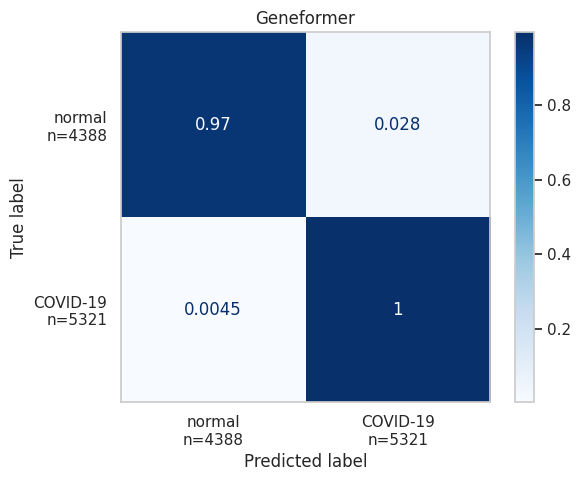

In [6]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
        custom_class_order=['normal', 'COVID-19'],
)

<Figure size 1500x1500 with 0 Axes>

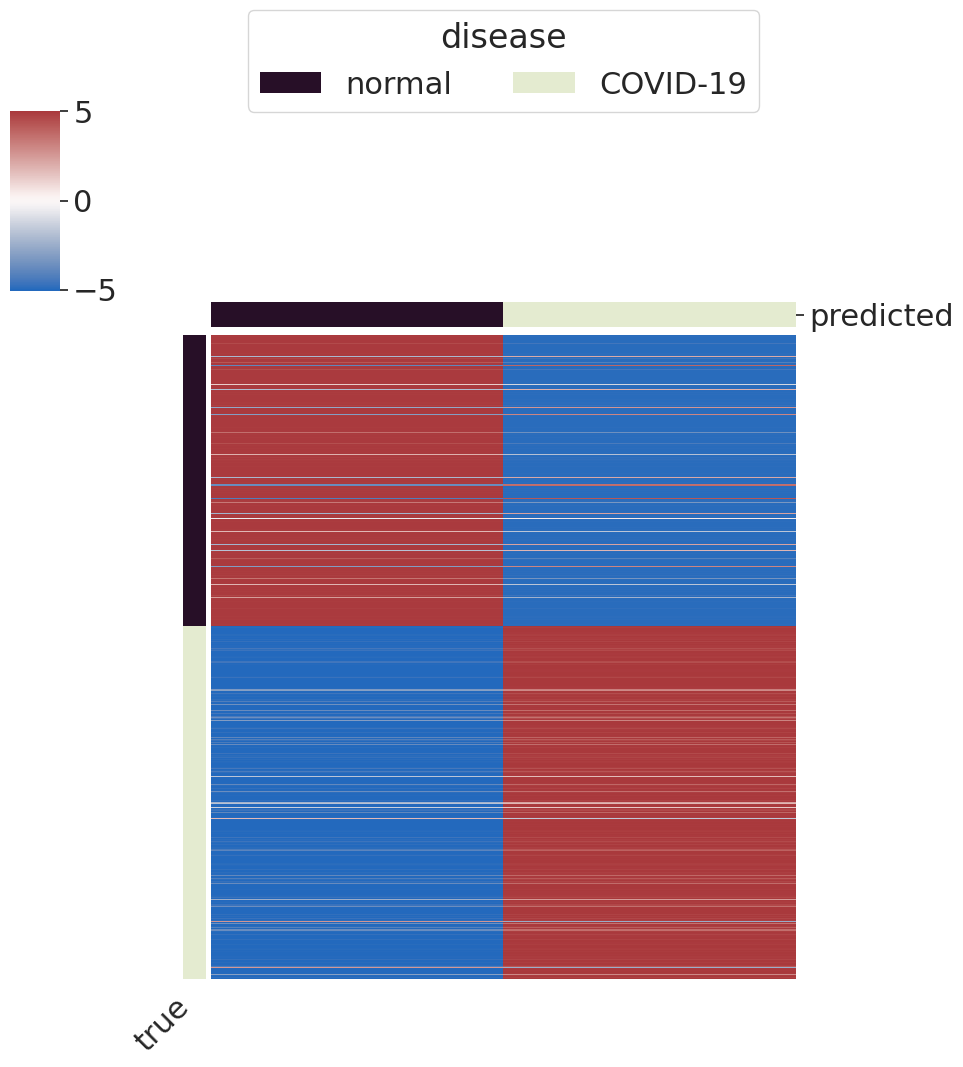

In [7]:
cc.plot_predictions(
    predictions_file=f"{output_dir}/{output_prefix}_pred_dict.pkl",
    id_class_dict_file=f"/hpcfs/users/a1841503/trained_classifiers/disease_classifier_v1_cellnexus/250910114246/disease_classifier_cellnexus_id_class_dict.pkl",
    title="disease",
    output_directory=output_dir,
    output_prefix=output_prefix,
    custom_class_order=['normal', 'COVID-19'],
)


In [8]:
all_metrics_test

{'conf_matrix':           COVID-19  normal
 COVID-19      5297      24
 normal         124    4264,
 'macro_f1': 0.9845818763214397,
 'acc': 0.9847564115768874,
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.9801732 , 0.9879216 , 0.9920237 , 0.99316317,
         0.99430264, 0.99453054, 0.99544211, 0.9961258 , 0.99658159,
         0.99703737, 0.99749316, 0.99772106, 0.99794895, 0.99817685,
         0.99817685, 0.99840474, 0.99863263, 0.99863263, 0.99863263,
         0.99886053, 0.99908842, 0.99908842, 0.99908842, 0.99931632,
         0.99954421, 0.99954421, 0.99954421, 0.99954421, 0.99977211,
         0.99977211, 0.99977211, 0.99977211, 0.99977211, 0.99977211,
         0.99977211, 0.99977211, 0.99977211, 0.99977211, 0.99977211,
         0.99977211, 0.99977211, 0.99977211, 0.99977211, 0.99977211,
         0.99977211, 0.99977211, 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.  